<a href="https://colab.research.google.com/github/AlexanderItaly/inflation_analysis/blob/main/inflation_analysis/inflation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analisi sull'effetto dell'inflazione sui rendimenti finanziari
* Verifica degli andamenti dell'inflazione in EU e US
* Calcolo dei rendimenti aggiustati all'inflazione
* Calcolo rendimenti rolling a 5 (10) anni aggiustati all'inflazione

<p>
<a href="https://colab.research.google.com/github/jumping2000/Quants/blob/master/inflation_analysis/inflation.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://github.com/jumping2000/Quants/blob/main/inflation_analysis/inflation.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>
</p>

## Bibliografia
*  https://medium.com/@lucamingarelli/easy-access-to-ecb-data-in-python-6015b65dcc0e
* https://medium.com/analytics-vidhya/adjusting-for-inflation-when-analysing-historical-data-with-python-9d69a8dcbc27
*  https://data.ecb.europa.eu/
*  https://www.investopedia.com/terms/i/inflation_adjusted_return.asp
*  https://pieriantraining.com/exploring-inflation-data-with-python/
*  https://www.franklintempleton.co.uk/articles/2023/brandywine-global/deconstructing-the-dynamic-duo-of-stocks-and-bonds

In [53]:
!pip install ecbdata cpi
from ecbdata import ecbdata
import cpi
import yfinance as yf
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from datetime import datetime

In [54]:
cpi.update()

### Inserisci i dati utili

In [55]:
start_date = '1980-02-01'
end_date = '2025-08-01'
eur_data = False # False se utilizzo i dati di inflazione americani per correggere i rendimenti, true se uso inflazionezione Europea
confronto_inflazione = False #  True se scarico entrambi i dati di inflazione e li visualizzo, se False scarico dati inflazione US
use_matplot = True # se True uso matplotlib altrimenti plotly


## Scarico dati da Yahoo Finance

In [56]:
#stocks=[["SP500","SPY"], ["SPDR Gold Shares","GLD"]] #,["iShares 7-10 Year Treasury Bonds","IEF"]] # ["Core S&P 500","CSSPX.MI"],["Ishares MSCI World","SWDA.MI"]]
#stocks = [["Ishares MSCI World","SWDA.MI"],["Invesco Phisycal Gold","SGLD.MI"]]
stocks = [["S&P500","^GSPC"]] #, ["Treasury Yield 10 Years","^TNX"]]
#stocks=[["Ishares MSCI World","SEMA.MI"], ["iShares MSCI EM","SEMA.MI"], ["Xtrackers Global Government Bond","XGSH.MI"]]
# DATI INIZIALI
nomi=list(np.array(stocks)[:,0])
tickers=list(np.array(stocks)[:,1])
pesi_percentuali = np.array([0.5, 0.5])

# SCARICO DA YAHOO
if len(tickers) == 1:
    ticker = tickers[0]
    data = yf.download(ticker, start=start_date, end=end_date, interval='1mo', auto_adjust=False)
    dati = data['Close'] # Select the 'Close' column as a Series
    pesi_percentuali = 1
    if isinstance(dati, pd.Series):
        dati = dati.to_frame() # Convert the Series to a DataFrame
        dati.columns = [ticker] # Rename the column of the DataFrame
else:
    dati = yf.download(tickers, start=start_date, end=end_date, interval='1mo', auto_adjust=False)['Close']
    dati = dati.reindex(tickers, axis=1)


# Rimuovere le righe con values mancanti
dati.dropna(inplace=True)
dati.index = dati.index.tz_localize(None)
dati.info()

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 487 entries, 1985-01-01 to 2025-07-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ^GSPC   487 non-null    float64
dtypes: float64(1)
memory usage: 7.6 KB



/tmp/ipython-input-201582936.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dati.dropna(inplace=True)


## Recupero dati inflazione europea

In [57]:
df_inflation = pd.DataFrame()
if confronto_inflazione == True:
    df_inflation = ecbdata.get_series('ICP.M.U2.N.000000.4.ANR', start=start_date)
    df_inflation['TIME_PERIOD'] = pd.to_datetime(df_inflation['TIME_PERIOD'])
    df_inflation.set_index('TIME_PERIOD', inplace=True)
    df_inflation.index.names = ['Date']
    df_inflation = df_inflation.rename(columns={'OBS_VALUE': 'EU_Inflation'})
    df_inflation = df_inflation[['EU_Inflation']]/100
    ## SOSTITUSICO 0 con 0.001 per evitare problemi con il calcolo dei ritorni inflation adjusted
    df_inflation.replace(0.0, 0.001, inplace=True)
    df_inflation


In [58]:
if confronto_inflazione == True:
    fig = plt.figure()
    df_inflation['EU_Inflation'].plot(figsize=(18,6))
    plt.axhline(0.02,ls='--',c='red')
    plt.axhline(0.00,ls='-.',c='black')
    plt.ylabel('YoY % Change')
    plt.title('EU Inflation');

## Recupero dati inflazione americana

In [59]:
cpi_items_df = cpi.series.get(seasonally_adjusted=False).to_dataframe()
cpi_items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   series_id            1462 non-null   object 
 1   year                 1462 non-null   int64  
 2   date                 1462 non-null   object 
 3   value                1462 non-null   float64
 4   period_id            1462 non-null   object 
 5   period_code          1462 non-null   object 
 6   period_abbreviation  1462 non-null   object 
 7   period_name          1462 non-null   object 
 8   period_month         1462 non-null   int64  
 9   period_type          1462 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 114.3+ KB


In [60]:
cpi_items_df = cpi_items_df[cpi_items_df['period_type']=='monthly']
cpi_items_df['date'] = pd.to_datetime(cpi_items_df['date'])
cpi_items_df = cpi_items_df.set_index('date')
cpi_items_df.sort_index(inplace=True)

In [61]:
a = datetime.strptime(start_date, '%Y-%m-%d')
start_date = str(a - relativedelta(years = 1))
cpi_items_df = cpi_items_df.loc[start_date:end_date]
#cpi_items_df

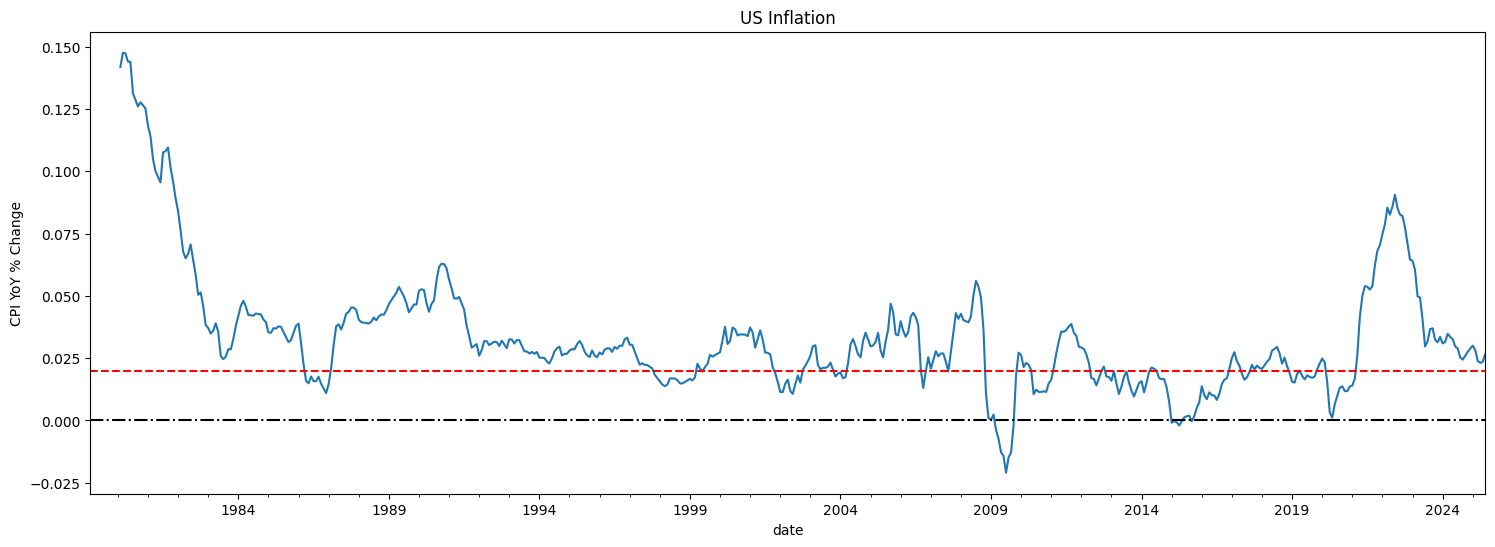

In [62]:
fig = plt.figure()
cpi_items_df['value'].pct_change(12).plot(figsize=(18,6))
plt.axhline(0.02,ls='--',c='red')
plt.axhline(0.00,ls='-.',c='black')
plt.ylabel('CPI YoY % Change');
plt.title('US Inflation');

In [63]:
if confronto_inflazione == True:
    df_inflation.insert(1, 'US_Inflation', cpi_items_df['value'].pct_change(12))
else:
    df_inflation['US_Inflation'] = cpi_items_df['value'].pct_change(12)
df_inflation.dropna(inplace=True)


In [64]:
df_inflation.index = df_inflation.index.tz_localize(None)
df_inflation

,US_Inflation
date,
1980-02-01,0.141823
1980-03-01,0.147564
1980-04-01,0.147309
1980-05-01,0.144056
1980-06-01,0.143845
...,...
2025-02-01,0.028215
2025-03-01,0.023907
2025-04-01,0.023113


In [65]:
if confronto_inflazione == True:
    if use_matplot == True:
        fig = plt.figure()
        df_inflation.plot(figsize=(18,6))
        plt.title('Inflazione Year over Year  per EU e US')
        plt.axhline(0.02,ls='--',c='red')
        plt.axhline(0.00,ls='-.',c='black')
        plt.xlabel('Date')
        plt.ylabel('Inflation YoY')
        plt.grid()
        plt.show()
    else:
        fig = px.line(
            data_frame=df_inflation,
            color_discrete_sequence=["#636EFA", "#EF553B", "#19D3F3", "#B6E880", "#FECB52", "#2ECB32","#FF6600","#0033CC"],
            template="plotly_dark",
            title = 'Inflazione Year over Year  per EU e US'
        )
        fig.update_traces(hovertemplate=None)
        fig.update_layout(
            yaxis_title='Inflation YoY',
            xaxis_title='Date',
            hovermode="x unified",
        )
        fig.add_hline(y=0.02)
        fig.show()


<Figure size 640x480 with 0 Axes>

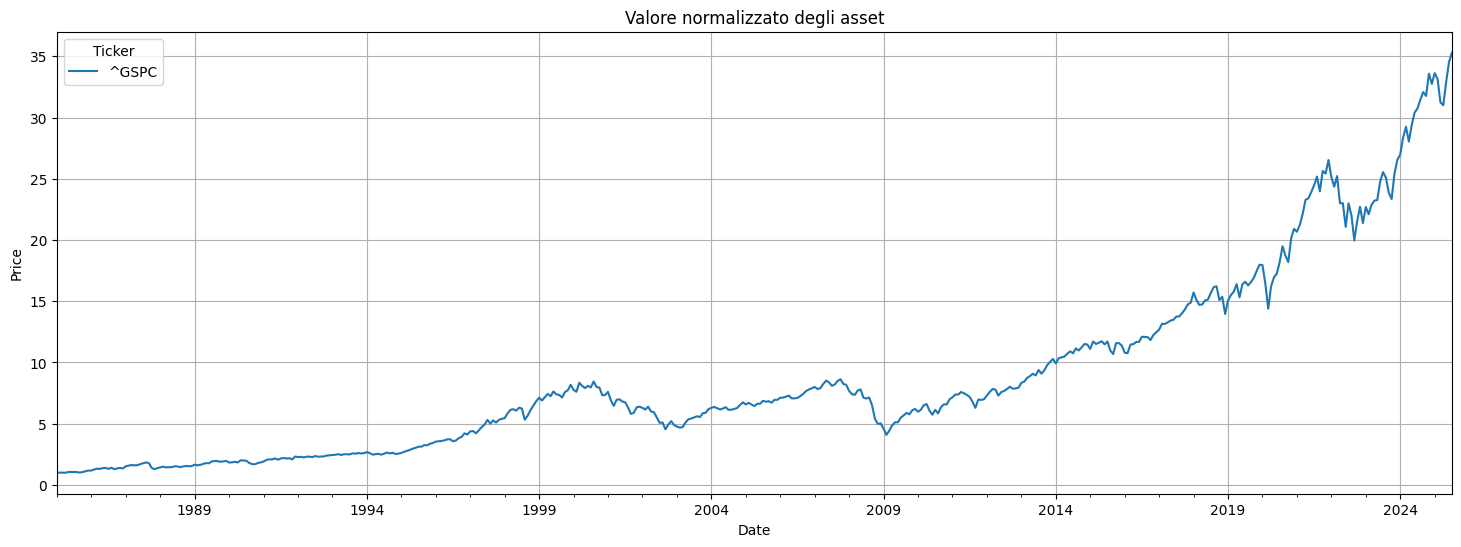

In [66]:
def get_norm(df):
    return df / df.iloc[0]

if use_matplot == True:
    fig = plt.figure()
    get_norm(dati).plot(figsize=(18,6))
    plt.title('Valore normalizzato degli asset')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid()
    plt.show()
else:
    fig = px.line(
        data_frame=get_norm(dati),
        color_discrete_sequence=["#636EFA", "#EF553B", "#19D3F3", "#B6E880", "#FECB52", "#2ECB32","#FF6600","#0033CC"],
        template="plotly_dark",
    )
    fig.update_traces(hovertemplate=None)
    fig.update_layout(
        title='Valore Normalizzato degli asset',
        xaxis_title='Date',
        yaxis_title='Price',
        hovermode="x unified",
        # text = ["Date", "Value"],
    )
    fig.show()

##Formule per i rendimenti
Rendimento annualizzato partendo dai rendimenti mensili:
$$
\text{Annualized Return} = \left( \prod_{i=1}^{n} (1 + r_i) \right)^{\frac{12}{n}} - 1
$$
<br>Formula semplificata (funziona bene se la volatilità dei rendimenti non è eccessiva): <br><br>
$$
\text{Annualized Return} = \left( 1 + MeanReturn \right)^{12} - 1
$$
<br>Per i rendimenti mensili aggiustati all'inflazione:
$$
\text{Return-adjusted}_{monthly} = \dfrac{1 + Return_{monthly}}{1+Inflation_{monthly}} -1
$$

In [67]:
# Calcola i rendimenti mensili
rendimenti = dati.pct_change().dropna()
# Calcola i rendimenti annualizzati
rendimento_annualizzato = (1 + rendimenti).prod() ** (12 / len(rendimenti)) - 1
print(f'Rendimento annualizzato {rendimento_annualizzato*100} %')

Rendimento annualizzato Ticker
^GSPC    9.197838
dtype: float64 %


In [68]:
#df_inflation.isnull().values.any()
df_inflation.drop(index=df_inflation.index[0], inplace=True)
# Dividere il tasso di inflazione annuale per 12 per ottenere il tasso di inflazione mensile
df_inflation_month = df_inflation / 12


In [69]:
# Calcolare i rendimenti aggiustati all'inflazione per ciascun ETF
if eur_data == True:
    rendimenti_adjusted = (1 + rendimenti).div(1 + df_inflation_month['EU_Inflation'], axis=0) - 1
else:
    rendimenti_adjusted = (1 + rendimenti).div(1 + df_inflation_month['US_Inflation'], axis=0) - 1
# Rinominare le colonne per indicare che sono i rendimenti aggiustati all'inflazione
if len(tickers) == 1:
    rendimenti_adjusted.name = f"{ticker}_adjusted" # Rename the Series
else:
    rendimenti_adjusted.columns = [f"{col}_real" for col in rendimenti.columns]
####
rendimento_annualizzato_adjusted = (1 + rendimenti_adjusted).prod() ** (12 / len(rendimenti_adjusted)) - 1
rendimento_annualizzato_adjusted
df_rendimenti = pd.concat([rendimenti, rendimenti_adjusted], axis=1)

In [70]:
# Calculate the cumulative daily returns (--> in uscita un array)
def cum_total_return(returns):
    return (1 + returns).cumprod() - 1

# Calculate the cumulative monthly returns
rendimentoCumulato = cum_total_return(rendimenti)
print(f'Rendimento cumulato nel periodo di osservazione:\n{rendimentoCumulato.iloc[-1]*100}%')
rendimentoCumulato_adjusted = cum_total_return(rendimenti_adjusted)
print(f'\nRendimento cumulato "inflation adjusted" nel periodo di osservazione:\n{rendimentoCumulato_adjusted.iloc[-1]*100}%')
df_rendimenti_cumulati = pd.concat([rendimentoCumulato, rendimentoCumulato_adjusted], axis=1)
#
#rapporto_rendimenti = [a / b for a, b in zip(rendimentoCumulato.iloc[-1].tolist(), rendimentoCumulato_adjusted.iloc[-1].tolist())]
#print(f'\nRapporto tra i rendimenti:\n{rapporto_rendimenti}')

Rendimento cumulato nel periodo di osservazione:
Ticker
^GSPC    3429.137652
Name: 2025-07-01 00:00:00, dtype: float64%

Rendimento cumulato "inflation adjusted" nel periodo di osservazione:
Ticker
^GSPC   NaN
Name: 2025-07-01 00:00:00, dtype: float64%


<Figure size 640x480 with 0 Axes>

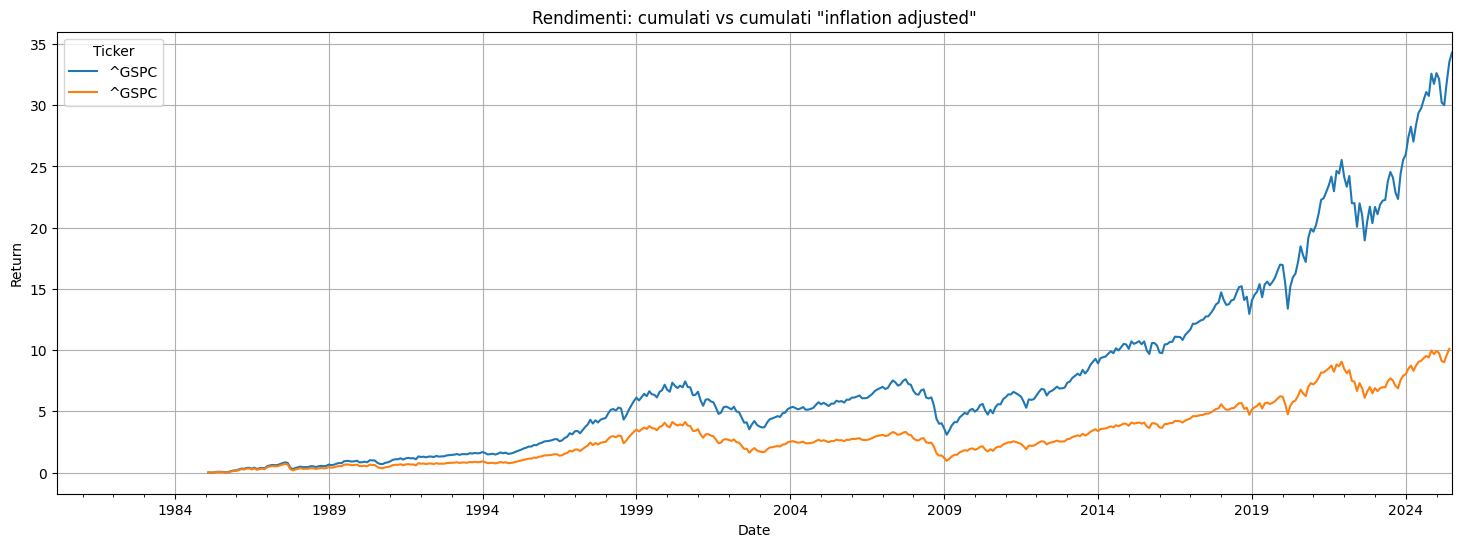

In [71]:
if use_matplot == True:
    fig = plt.figure()
    df_rendimenti_cumulati.plot(figsize=(18,6))
    plt.title('Rendimenti: cumulati vs cumulati "inflation adjusted"')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.grid()
    plt.show()
else:
    fig = px.line(
        data_frame=df_rendimenti_cumulati,
        color_discrete_sequence=["#636EFA", "#EF553B", "#19D3F3", "#B6E880", "#FECB52", "#2ECB32","#FF6600","#0033CC"],
        template="plotly_dark",
        title = 'Rendimenti: cumulati vs cumulati "inflation adjusted"'
    )
    fig.show()

## Analisi rolling

In [72]:
# Funzione per calcolare il rendimento rolling annualizzato
def rolling_return(returns, window):
    return (1 + returns.rolling(window=window).apply(lambda x: np.prod(1 + x) - 1)).pow(12/window) - 1
YEARS = 5
rolling_return_assets = rolling_return(df_rendimenti, 12*YEARS)

<Figure size 640x480 with 0 Axes>

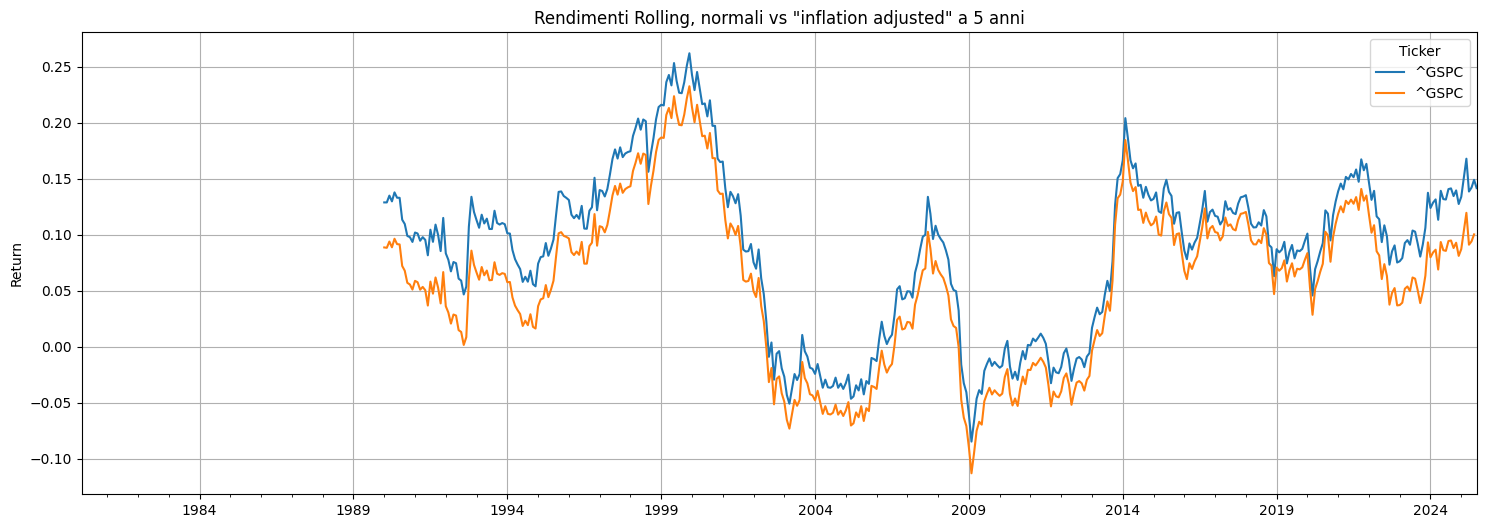

In [73]:
if use_matplot == True:
    fig = plt.figure()
    rolling_return_assets.plot(figsize=(18,6))
    plt.title(f'Rendimenti Rolling, normali vs "inflation adjusted" a {YEARS} anni')
    plt.ylabel('Return')
    plt.grid()
    plt.show()
else:
    fig = px.line(
        data_frame=rolling_return_assets,
        color_discrete_sequence=["#636EFA", "#EF553B", "#19D3F3", "#B6E880", "#FECB52", "#2ECB32","#FF6600","#0033CC"],
        template="plotly_dark",
        title = f'Rendimenti Rolling, normali vs "inflation adjusted" a {YEARS} anni'
    )
    fig.show()